# Water Levels and Tides

In [1]:
import async_retriever as ar
import matplotlib.pyplot as plt
import pandas as pd

We can get water level recordings of a NOAA's water level station through the CO-OPS API, Let's get the data for 8534720 station (Atlantic City, NJ), during 2012,. Note that this CO-OPS product has a 31-day for a single request, so we have to break the request accordingly.

In [2]:
station_id = "8534720"
start = pd.to_datetime("2012-01-01")
end = pd.to_datetime("2012-12-31")

s = start
dates = []
for e in pd.date_range(start, end, freq="m"):
    dates.append((s.date(), e.date()))
    s = e + pd.offsets.MonthBegin()

url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

urls, kwds = zip(
    *(
        (
            url,
            {
                "params": {
                    "product": "water_level",
                    "application": "web_services",
                    "begin_date": f'{s.strftime("%Y%m%d")}',
                    "end_date": f'{e.strftime("%Y%m%d")}',
                    "datum": "MSL",
                    "station": f"{station_id}",
                    "time_zone": "GMT",
                    "units": "metric",
                    "format": "json",
                }
            },
        )
        for s, e in dates
    )
)

resp = ar.retrieve(urls, read="json", request_kwds=kwds)
wl_list = []
for rjson in resp:
    wl = pd.DataFrame.from_dict(rjson["data"])
    wl["t"] = pd.to_datetime(wl.t)
    wl = wl.set_index(wl.t).drop(columns="t")
    wl["v"] = pd.to_numeric(wl.v, errors="coerce")
    wl_list.append(wl)
water_level = pd.concat(wl_list).sort_index()
water_level.attrs = rjson["metadata"]

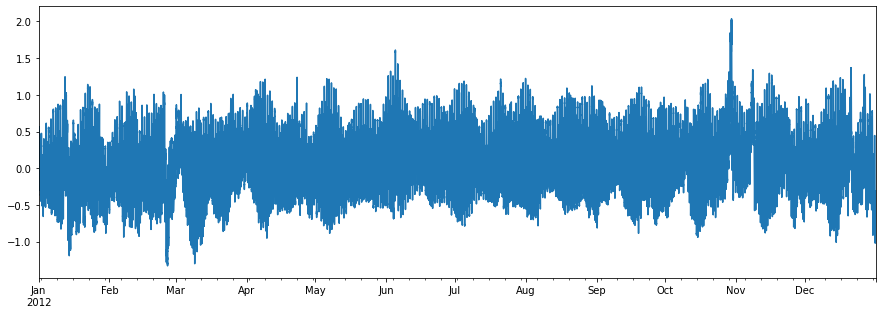

In [3]:
ax = water_level.v.plot(figsize=(15, 5))
ax.set_xlabel("")
ax.figure.savefig("_static/water_level.png", bbox_inches="tight", facecolor="w")

Now, let's see an example without any payload or headers. Here's how we can retrieve
harmonic constituents from CO-OPS:

In [4]:
stations = [
    "8410140",
    "8411060",
    "8413320",
    "8418150",
    "8419317",
    "8419870",
    "8443970",
    "8447386",
]

base_url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations"
urls = [f"{base_url}/{i}/harcon.json?units=metric" for i in stations]
resp = ar.retrieve(urls, "json")

amp_list = []
phs_list = []
for rjson in resp:
    sid = rjson["self"].rsplit("/", 2)[1]
    const = pd.DataFrame.from_dict(rjson["HarmonicConstituents"]).set_index("name")
    amp = const.rename(columns={"amplitude": sid})[sid]
    phase = const.rename(columns={"phase_GMT": sid})[sid]
    amp_list.append(amp)
    phs_list.append(phase)

amp = pd.concat(amp_list, axis=1)
phs = pd.concat(phs_list, axis=1)

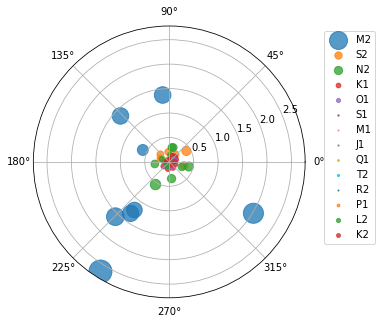

In [5]:
const = [
    "M2",
    "S2",
    "N2",
    "K1",
    "O1",
    "S1",
    "M1",
    "J1",
    "Q1",
    "T2",
    "R2",
    "P1",
    "L2",
    "K2",
]

ax = plt.subplot(111, projection="polar")
ax.figure.set_size_inches(5, 5)
for i in const:
    phs_ord = phs.loc[i].sort_values()
    amp_ord = amp.loc[i][phs_ord.index]
    ax.scatter(phs_ord, amp_ord, s=amp_ord * 200, cmap="hsv", alpha=0.75, label=i)

ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
ax.figure.savefig("_static/tides.png", bbox_inches="tight", facecolor="w")